# Решение задачи "Предсказание ухода клиента" RuCode-3

В этом ноутбуке мы будем решать задачу предсказания ухода клиента классическими моделями машинного обучения.

### Скачиваем данные на Google Colab и распаковываем:

In [ ]:
! wget "https://s560sas.storage.yandex.net/rdisk/8626f1e2bac415ff2176185dcca3a5974a6f2b50a083885f996a593a16ead80a/606b4620/aZ8Akc9CqtcaAMvg9MkExYyYYMX8hXYeNPK99Ia5tsOFom1LgRnfPgaTeJkHU_jYvoH98i8j8rBNncAwJLGFcQ==?uid=316082386&filename=train_data.csv&disposition=attachment&hash=&limit=0&content_type=text%2Fplain&owner_uid=316082386&fsize=4549012&hid=3a1ecfed59ea4943d3dcdb64bac15064&media_type=spreadsheet&tknv=v2&etag=4c73979b32123b34d92014446f87139c&rtoken=CUcHWcXINWD4&force_default=yes&ycrid=na-93d7925b588ed462faf5085776657bf8-downloader5h&ts=5bf3cdec5c800&s=dbf6dfeccb0cb159a1365243ac5c20f44b4da35bbf834ad84732fe3663905541&pb=U2FsdGVkX19SF3rpV6pn0ottlfbG8IrNijUtqK2uPG1GtzDBm16JmuGRZkSYUs3hI0H8EkoiYuw1nSwUuItpNfS4ifPipUMO-Fq8yymciFE" -O train_data.csv 
! wget "https://s561sas.storage.yandex.net/rdisk/d2d03ac4e610f87ac585efaca6833f10983610a28348cffff0e16239f7594c02/606b462e/aZ8Akc9CqtcaAMvg9MkExX6M2xJVY50w7Ubq5fEl9PsO-pGvYZMIxC2wDhNR2QoLYGftTAmgDsZCcz9lkMT0dg==?uid=316082386&filename=test_data.csv&disposition=attachment&hash=&limit=0&content_type=text%2Fplain&owner_uid=316082386&fsize=1116189&hid=4bd483eb312ca222d92db537e2bde68f&media_type=spreadsheet&tknv=v2&etag=7975770abc5c3426a67d6ad6175ad4b6&rtoken=QpB3FfQ8vnGI&force_default=yes&ycrid=na-6e7e5a4a37b4bd6b27c02d6a7263bdf5-downloader5h&ts=5bf3cdf9b6780&s=d16f27b4df4f8536318704a1e7b8eddf5f8b23f4836e7b03fab2dcceb2e79c13&pb=U2FsdGVkX1_6ALLHkLRz9w7MN5ydO9-PijBnjMQ25xWFU0XAVIN8CkjY_SeDmFJkHywngivgBkdSrm7TbOVyOdXjtDAmaeRWe8YJQmsLQ2I" -O test_data.csv
! wget "https://s224vla.storage.yandex.net/rdisk/00f0971f1c8404bd1c7ced6fa1ab8be1421cc1ac9b7e75992aa60bccf0ed5c08/606b4640/aZ8Akc9CqtcaAMvg9MkExc0MoixDyFumKX_DJgNXQEqspzw5mIvVBK_Pfd1slZGwnr7pJn5bQCpOQpnKLr6dtw==?uid=316082386&filename=test_answer.csv&disposition=attachment&hash=&limit=0&content_type=text%2Fplain&owner_uid=316082386&fsize=15018&hid=c3dea865981bdb18ae9471e5833a34bc&media_type=spreadsheet&tknv=v2&etag=948dd6b273c97744d8611256ecb0fe16&rtoken=cchVWKAjwG1e&force_default=yes&ycrid=na-f680cd14076cc535599704f36757c002-downloader5h&ts=5bf3ce0ae1000&s=a2dd19f9fcbaffe6faf5c78082df97b9be217e58693b52b29d222b9478be0c29&pb=U2FsdGVkX19podS0vkHE3l4xyPxwGat-dyXsSs864tAWo3PFHU1ULAkEpyEmi-C9QoiYs1vw3xsli-suI33gV0lMv7r8vKgxczhjL9Dwu6w" -O test_answer.csv

In [ ]:
! ls

sample_data  test_answer.csv  test_data.csv  train_data.csv


## Строим решение:

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные и посмотрим на них:

In [ ]:
train_data = pd.read_csv('./train_data.csv').drop('Unnamed: 0', axis=1)
train_data.head()

,имя,возраст,пол,тип_региона_проживания,тип_обслуживания,дата_регистрации,реферальная_ссылка,устройство,последний_визит,дней_с_момента_последнего_логина,среднее_время,средний_чек,частота_посещений,баллы,скидки,жалобы,статус_жалобы,фидбек,риск_ухода
0,Lucio Gabriel,49,F,Town,Basic Membership,2015-08-07,Yes,Smartphone,02:17:14,23,47.450000,41083.45,29.0,657.67,No,Yes,Solved,Poor Product Quality,5
1,Shaina Taube,57,M,NaN,Gold Membership,2015-05-14,Yes,Desktop,21:25:14,19,826.085388,34196.17,21.0,701.51,Yes,No,Not Applicable,Poor Customer Service,4
2,Maryln Roger,37,M,Town,Silver Membership,2017-03-14,No,Desktop,10:23:23,6,145.450000,26744.56,Error,715.44,Yes,Yes,No Information Available,Poor Customer Service,4
3,Alaina Densmore,23,F,City,Silver Membership,2015-09-25,Yes,?,00:03:10,20,170.090000,18016.81,18.0,743.10,Yes,Yes,No Information Available,Too many ads,3
4,Bernadine Krasner,30,M,NaN,Premium Membership,2016-12-13,Yes,Both,08:54:23,14,715.040000,17044.98,17.0,717.35,Yes,No,Not Applicable,Too many ads,3


## Предобработка данных

Удалим ненужные колонки:

In [ ]:
train_data = train_data.drop(['имя', 'последний_визит'], axis=1)

Признак "дата регистрации" переведем в кол-во дней от начала регистрации до 10 апреля 2021 года:

In [ ]:
datetime_object_now = datetime.strptime('2021 04 10', '%Y %m %d')
train_data['дата_регистрации'] = \
list(map(lambda x: (datetime_object_now - datetime.strptime(x.replace('-', ' '), '%Y %m %d')).days, train_data['дата_регистрации']))

Посмотрим на колонки:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29593 entries, 0 to 29592
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   возраст                           29593 non-null  int64  
 1   пол                               29593 non-null  object 
 2   тип_региона_проживания            25235 non-null  object 
 3   тип_обслуживания                  29593 non-null  object 
 4   дата_регистрации                  29593 non-null  int64  
 5   реферальная_ссылка                29593 non-null  object 
 6   устройство                        29593 non-null  object 
 7   дней_с_момента_последнего_логина  29593 non-null  int64  
 8   среднее_время                     29593 non-null  float64
 9   средний_чек                       29593 non-null  float64
 10  частота_посещений                 29593 non-null  object 
 11  баллы                             26804 non-null  float64
 12  скид

#### Выделим все категориальные колонки и посмотрим на значения в них:

In [ ]:
categorical_columns = [x for x in train_data.columns if train_data[x].dtype == 'object']

In [ ]:
categorical_columns

['пол',
 'тип_региона_проживания',
 'тип_обслуживания',
 'реферальная_ссылка',
 'устройство',
 'частота_посещений',
 'скидки',
 'жалобы',
 'статус_жалобы',
 'фидбек']

In [ ]:
train_data['пол'].value_counts()

M          14774
F          14770
Unknown       49
Name: пол, dtype: int64

In [ ]:
train_data['тип_региона_проживания'].value_counts()

Town       11282
City       10236
Village     3717
Name: тип_региона_проживания, dtype: int64

In [ ]:
train_data['тип_обслуживания'].value_counts()

Basic Membership       6188
No Membership          6144
Gold Membership        5488
Silver Membership      4797
Premium Membership     3519
Platinum Membership    3457
Name: тип_обслуживания, dtype: int64

In [ ]:
train_data['реферальная_ссылка'].value_counts()

No     12691
Yes    12585
?       4317
Name: реферальная_ссылка, dtype: int64

In [ ]:
train_data['устройство'].value_counts()

Desktop       11178
Smartphone    11140
?              4257
Both           3018
Name: устройство, dtype: int64

In [ ]:
train_data['частота_посещений'].value_counts()

Error                  2825
13.0                   1129
19.0                   1118
8.0                    1102
14.0                   1081
                       ... 
28.39730232134528         1
30.144339688134668        1
47.74305199570827         1
-11.336991977265093       1
-9.154338861698612        1
Name: частота_посещений, Length: 1305, dtype: int64

In [ ]:
train_data['скидки'].value_counts()

Yes    16211
No     13382
Name: скидки, dtype: int64

In [ ]:
train_data['жалобы'].value_counts()

No     14856
Yes    14737
Name: жалобы, dtype: int64

In [ ]:
train_data['статус_жалобы'].value_counts()

Not Applicable              14856
Solved                       3727
Unsolved                     3685
Solved in Follow-up          3675
No Information Available     3650
Name: статус_жалобы, dtype: int64

In [ ]:
train_data['фидбек'].value_counts()

Poor Customer Service       5040
No reason specified         5037
Poor Product Quality        5036
Too many ads                5032
Poor Website                5013
Reasonable Price            1148
User Friendly Website       1115
Quality Customer Care       1086
Products always in Stock    1086
Name: фидбек, dtype: int64

Удалим колонку "частота посещений", потому что в ней много пропусков и непонятных значений:

In [ ]:
train_data = train_data.drop(['частота_посещений'], axis=1)

Переведем признаки "скидки" и "жалобы" в вид бинарных переменных:

In [ ]:
train_data['скидки'] = train_data['скидки'].apply(lambda x: 1 if x == 'Yes' else 0)
train_data['жалобы'] = train_data['жалобы'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
train_data.head()

,возраст,пол,тип_региона_проживания,тип_обслуживания,дата_регистрации,реферальная_ссылка,устройство,дней_с_момента_последнего_логина,среднее_время,средний_чек,баллы,скидки,жалобы,статус_жалобы,фидбек,риск_ухода
0,49,F,Town,Basic Membership,2073,Yes,Smartphone,23,47.450000,41083.45,657.67,0,1,Solved,Poor Product Quality,5
1,57,M,NaN,Gold Membership,2158,Yes,Desktop,19,826.085388,34196.17,701.51,1,0,Not Applicable,Poor Customer Service,4
2,37,M,Town,Silver Membership,1488,No,Desktop,6,145.450000,26744.56,715.44,1,1,No Information Available,Poor Customer Service,4
3,23,F,City,Silver Membership,2024,Yes,?,20,170.090000,18016.81,743.10,1,1,No Information Available,Too many ads,3
4,30,M,NaN,Premium Membership,1579,Yes,Both,14,715.040000,17044.98,717.35,1,0,Not Applicable,Too many ads,3


#### Работа с пропусками

Удалим строки, для которых неизвестен пол:

In [ ]:
train_data = train_data[train_data['пол']!='Unknown']

И переведем признак "пол" в вид бинарной переменной:

In [ ]:
train_data['пол'] = train_data['пол'].apply(lambda x: 1 if x == 'M' else 0)

Заполним пропуски в колонках "тип_региона_проживания" и "баллы":

In [ ]:
# заполняем пропуски самым популярным значением
train_data['тип_региона_проживания'] = train_data['тип_региона_проживания'].fillna('Town')

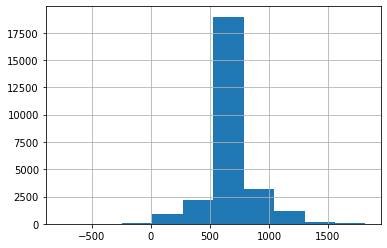

In [ ]:
train_data['баллы'].hist()

In [ ]:
train_data['баллы'] = train_data['баллы'].fillna(0)

В колонке "реферальная_ссылка" для людей, о которых нет информации, считаем, что реферальной ссылки у них нет:

In [ ]:
mask = train_data['реферальная_ссылка']=='?'
train_data.loc[mask, 'реферальная_ссылка'] = 'No'

Вот что получилось на данном этапе:

In [ ]:
train_data['реферальная_ссылка'] = train_data['реферальная_ссылка'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
train_data.head()

,возраст,пол,тип_региона_проживания,тип_обслуживания,дата_регистрации,реферальная_ссылка,устройство,дней_с_момента_последнего_логина,среднее_время,средний_чек,баллы,скидки,жалобы,статус_жалобы,фидбек,риск_ухода
0,49,0,Town,Basic Membership,2073,1,Smartphone,23,47.450000,41083.45,657.67,0,1,Solved,Poor Product Quality,5
1,57,1,Town,Gold Membership,2158,1,Desktop,19,826.085388,34196.17,701.51,1,0,Not Applicable,Poor Customer Service,4
2,37,1,Town,Silver Membership,1488,0,Desktop,6,145.450000,26744.56,715.44,1,1,No Information Available,Poor Customer Service,4
3,23,0,City,Silver Membership,2024,1,?,20,170.090000,18016.81,743.10,1,1,No Information Available,Too many ads,3
4,30,1,Town,Premium Membership,1579,1,Both,14,715.040000,17044.98,717.35,1,0,Not Applicable,Too many ads,3


#### Переводим категориальные признаки в числовые

Посмотрим, какие категориальные признаки у нас остались:

In [ ]:
categorical_columns = [x for x in train_data.columns if train_data[x].dtype == 'object']
categorical_columns

['тип_региона_проживания',
 'тип_обслуживания',
 'устройство',
 'статус_жалобы',
 'фидбек']

Бинаризуем все оставшиеся категориальные переменные:

In [ ]:
train_data = pd.get_dummies(train_data, categorical_columns)
train_data.head()

,возраст,пол,дата_регистрации,реферальная_ссылка,дней_с_момента_последнего_логина,среднее_время,средний_чек,баллы,скидки,жалобы,риск_ухода,тип_региона_проживания_City,тип_региона_проживания_Town,тип_региона_проживания_Village,тип_обслуживания_Basic Membership,тип_обслуживания_Gold Membership,тип_обслуживания_No Membership,тип_обслуживания_Platinum Membership,тип_обслуживания_Premium Membership,тип_обслуживания_Silver Membership,устройство_?,устройство_Both,устройство_Desktop,устройство_Smartphone,статус_жалобы_No Information Available,статус_жалобы_Not Applicable,статус_жалобы_Solved,статус_жалобы_Solved in Follow-up,статус_жалобы_Unsolved,фидбек_No reason specified,фидбек_Poor Customer Service,фидбек_Poor Product Quality,фидбек_Poor Website,фидбек_Products always in Stock,фидбек_Quality Customer Care,фидбек_Reasonable Price,фидбек_Too many ads,фидбек_User Friendly Website
0,49,0,2073,1,23,47.450000,41083.45,657.67,0,1,5,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,57,1,2158,1,19,826.085388,34196.17,701.51,1,0,4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,37,1,1488,0,6,145.450000,26744.56,715.44,1,1,4,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,23,0,2024,1,20,170.090000,18016.81,743.10,1,1,3,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,30,1,1579,1,14,715.040000,17044.98,717.35,1,0,3,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


И, наконец, поделим данные на признаки (Х) и целевую переменную (y):

In [ ]:
y = train_data['риск_ухода']
X = train_data.drop('риск_ухода', axis=1)

## Строим модель

Попробуем решить задачу линейной регрессией, случайным лесом и градиентным бустингом.

In [ ]:
from sklearn import ensemble, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
linreg = linear_model.LinearRegression()
rf = ensemble.RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=7)
gb = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=5, min_samples_split=10)

In [ ]:
linreg.fit(X, y)
rf.fit(X, y)
gb.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Предобрабатываем тестовые данные

In [ ]:
test_data = pd.read_csv('./test_data.csv').drop('Unnamed: 0', axis=1)
test_data.head()

,имя,возраст,пол,тип_региона_проживания,тип_обслуживания,дата_регистрации,реферальная_ссылка,устройство,последний_визит,дней_с_момента_последнего_логина,среднее_время,средний_чек,частота_посещений,баллы,скидки,жалобы,статус_жалобы,фидбек
0,Janelle Eisenman,30,F,City,No Membership,2015-01-23,Yes,Both,18:17:55,5,326.140000,19503.09,15.0,694.520000,Yes,No,Not Applicable,Poor Product Quality
1,Azucena Sun,29,F,Town,No Membership,2017-12-03,No,?,17:22:04,15,338.230000,6648.41,33.460205347560084,NaN,Yes,No,Not Applicable,Too many ads
2,Nikki Ranger,10,F,Town,Basic Membership,2015-07-02,No,Smartphone,23:53:45,13,154.050000,5415.97,14.0,866.803902,No,No,Not Applicable,Too many ads
3,Rex Kizer,55,F,City,Silver Membership,2017-12-12,Yes,?,03:33:11,13,1227.654536,5576.82,24.0,686.090000,No,Yes,Solved in Follow-up,Poor Product Quality
4,Christiana Dalzell,42,F,Village,Gold Membership,2017-06-20,No,?,23:21:04,11,69.330000,39146.00,16.0,666.440000,No,No,Not Applicable,Poor Website


In [ ]:
datetime_object_now = datetime.strptime('2021 04 10', '%Y %m %d')
test_data['дата_регистрации'] = \
list(map(lambda x: (datetime_object_now - datetime.strptime(x.replace('-', ' '), '%Y %m %d')).days, test_data['дата_регистрации']))

In [ ]:
test_data = test_data.drop(['имя', 'последний_визит', 'частота_посещений'], axis=1)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7399 entries, 0 to 7398
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   возраст                           7399 non-null   int64  
 1   пол                               7399 non-null   object 
 2   тип_региона_проживания            6329 non-null   object 
 3   тип_обслуживания                  7399 non-null   object 
 4   дата_регистрации                  7399 non-null   int64  
 5   реферальная_ссылка                7399 non-null   object 
 6   устройство                        7399 non-null   object 
 7   дней_с_момента_последнего_логина  7399 non-null   int64  
 8   среднее_время                     7399 non-null   float64
 9   средний_чек                       7399 non-null   float64
 10  баллы                             6745 non-null   float64
 11  скидки                            7399 non-null   object 
 12  жалобы

In [ ]:
test_data['пол'].value_counts()

F          3720
M          3669
Unknown      10
Name: пол, dtype: int64

In [ ]:
test_data['скидки'] = test_data['скидки'].apply(lambda x: 1 if x == 'Yes' else 0)
test_data['жалобы'] = test_data['жалобы'].apply(lambda x: 1 if x == 'Yes' else 0)

test_data['тип_региона_проживания'] = test_data['тип_региона_проживания'].fillna('Town')
test_data['баллы'] = test_data['баллы'].fillna(0)

mask = test_data['реферальная_ссылка']=='?'
test_data.loc[mask, 'реферальная_ссылка'] = 'No'
test_data['реферальная_ссылка'] = test_data['реферальная_ссылка'].apply(lambda x: 1 if x == 'Yes' else 0)

mask = test_data['пол']=='Unknown'
test_data.loc[mask, 'пол'] = 'F'
test_data['пол'] = test_data['пол'].apply(lambda x: 1 if x == 'M' else 0)

In [ ]:
categorical_columns

['тип_региона_проживания',
 'тип_обслуживания',
 'устройство',
 'статус_жалобы',
 'фидбек']

In [ ]:
test_data.head()

,возраст,пол,тип_региона_проживания,тип_обслуживания,дата_регистрации,реферальная_ссылка,устройство,дней_с_момента_последнего_логина,среднее_время,средний_чек,баллы,скидки,жалобы,статус_жалобы,фидбек
0,30,0,City,No Membership,2269,1,Both,5,326.140000,19503.09,694.520000,0,0,Not Applicable,Poor Product Quality
1,29,0,Town,No Membership,1224,0,?,15,338.230000,6648.41,0.000000,0,0,Not Applicable,Too many ads
2,10,0,Town,Basic Membership,2109,0,Smartphone,13,154.050000,5415.97,866.803902,0,0,Not Applicable,Too many ads
3,55,0,City,Silver Membership,1215,1,?,13,1227.654536,5576.82,686.090000,0,0,Solved in Follow-up,Poor Product Quality
4,42,0,Village,Gold Membership,1390,0,?,11,69.330000,39146.00,666.440000,0,0,Not Applicable,Poor Website


In [ ]:
test_data = pd.get_dummies(test_data, categorical_columns)
test_data.head()

,возраст,пол,дата_регистрации,реферальная_ссылка,дней_с_момента_последнего_логина,среднее_время,средний_чек,баллы,скидки,жалобы,тип_региона_проживания_City,тип_региона_проживания_Town,тип_региона_проживания_Village,тип_обслуживания_Basic Membership,тип_обслуживания_Gold Membership,тип_обслуживания_No Membership,тип_обслуживания_Platinum Membership,тип_обслуживания_Premium Membership,тип_обслуживания_Silver Membership,устройство_?,устройство_Both,устройство_Desktop,устройство_Smartphone,статус_жалобы_No Information Available,статус_жалобы_Not Applicable,статус_жалобы_Solved,статус_жалобы_Solved in Follow-up,статус_жалобы_Unsolved,фидбек_No reason specified,фидбек_Poor Customer Service,фидбек_Poor Product Quality,фидбек_Poor Website,фидбек_Products always in Stock,фидбек_Quality Customer Care,фидбек_Reasonable Price,фидбек_Too many ads,фидбек_User Friendly Website
0,30,0,2269,1,5,326.140000,19503.09,694.520000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,29,0,1224,0,15,338.230000,6648.41,0.000000,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,10,0,2109,0,13,154.050000,5415.97,866.803902,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,55,0,1215,1,13,1227.654536,5576.82,686.090000,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,42,0,1390,0,11,69.330000,39146.00,666.440000,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
train_data.shape, test_data.shape

((29544, 16), (7399, 15))

## Получаем предскзаания моделей:

In [ ]:
y_test_linreg = linreg.predict(test_data)

In [ ]:
y_test_rf = rf.predict(test_data)

In [ ]:
y_test_gb = gb.predict(test_data)

## Тестируем полученное решение

In [ ]:
y_test_true = np.array(pd.read_csv('./test_answer.csv')).flatten()

In [ ]:
y_test_true

array([4, 4, 5, ..., 4, 5, 1])

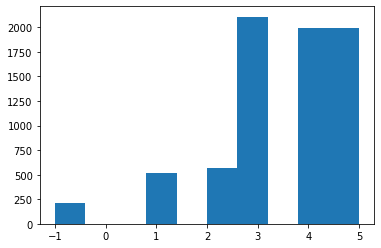

In [ ]:
plt.hist(y_test_true);

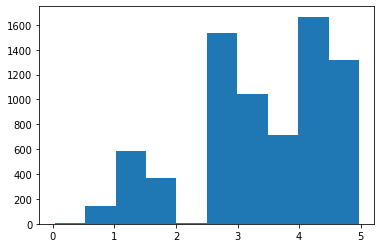

In [ ]:
plt.hist(y_test_rf);

In [ ]:
mean_squared_error(y_test_linreg, y_test_true)

0.8223351808975198

In [ ]:
(200 - sum((y_test_linreg - y_test_true)**2)**0.5) / 20

6.099853206781588

In [ ]:
(200 - sum((y_test_rf - y_test_true)**2)**0.5) / 20

6.248396055229982

In [ ]:
(200 - sum((y_test_gb - y_test_true)**2)**0.5) / 20

6.150496539592652

## Пробуем CatBoost

CatBoost умеет работать с категориальными признаками, поэтому для него предобработаем данные точно так же, как и для моделей выше, но не будем бинаризовать категориальные переменные.

In [ ]:
! pip install catboost

     |████████████████████████████████| 67.3MB 69kB/s 


In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
categorical_columns = [x for x in train_data.columns if train_data[x].dtype == 'object']

In [ ]:
model = CatBoostRegressor(iterations=500,
                           depth=3,
                           learning_rate=0.1,
                           loss_function='RMSE',
                           cat_features=categorical_columns,
                           verbose=True)
# train the model
model.fit(X, y)

0:	learn: 1.3372716	total: 64.7ms	remaining: 32.3s
1:	learn: 1.2742520	total: 79.1ms	remaining: 19.7s
2:	learn: 1.2202224	total: 88.3ms	remaining: 14.6s
3:	learn: 1.1727003	total: 102ms	remaining: 12.7s
4:	learn: 1.1333383	total: 112ms	remaining: 11s
5:	learn: 1.0990854	total: 121ms	remaining: 9.94s
6:	learn: 1.0708760	total: 130ms	remaining: 9.16s
7:	learn: 1.0474047	total: 139ms	remaining: 8.54s
8:	learn: 1.0279305	total: 148ms	remaining: 8.08s
9:	learn: 1.0119891	total: 157ms	remaining: 7.71s
10:	learn: 0.9984903	total: 173ms	remaining: 7.69s
11:	learn: 0.9873364	total: 182ms	remaining: 7.41s
12:	learn: 0.9783751	total: 191ms	remaining: 7.17s
13:	learn: 0.9710019	total: 200ms	remaining: 6.96s
14:	learn: 0.9644990	total: 210ms	remaining: 6.78s
15:	learn: 0.9585426	total: 222ms	remaining: 6.73s
16:	learn: 0.9536538	total: 232ms	remaining: 6.59s
17:	learn: 0.9498532	total: 241ms	remaining: 6.44s
18:	learn: 0.9457833	total: 253ms	remaining: 6.41s
19:	learn: 0.9426761	total: 266ms	remain

In [ ]:
catboost_ans = model.predict(test_data)

In [ ]:
(200 - sum((catboost_ans - y_test_true)**2)**0.5) / 20

6.269933982910803

In [ ]:
mean_squared_error(catboost_ans, y_test_true)

0.7521769153584884

In [ ]:
mean_squared_error(model.predict(train_data), y)

0.8093683192170281

In [ ]:
catboost_ans

array([4.99465171, 4.99999865, 4.90038198, ..., 3.99848139, 4.99999869,
       0.99817369])